# Infomap
Multi-level network clustering based on the [Map equation](http://www.mapequation.org/publications.html#Rosvall-Axelsson-Bergstrom-2009-Map-equation).


### The Map Equation

\begin{equation*}
    L(M) = q_\curvearrowright H(\mathcal{Q}) + \sum_{i = 1}^{m}{p_{\circlearrowright}^i H(\mathcal{P}^i)}
\end{equation*}

$L(M)$ measures the amount of information it takes to describe a random walk on a network given a partition of the network into modules $M$. It is a sum of the amount of information needed to describe the movements _between_ and _within_ the modules, which balances the goodness of fit with the complexity of the model. For more information, see [www.mapequation.org](http://www.mapequation.org).

### Import Infomap
Infomap includes an `examples/python` folder with some examples, including this notebook. Run `make` in that directory to build the python interface to a local folder.

The `infomap` package exposes two classes, `Infomap` and `MemInfomap`, that wraps an input `network`, an output `tree`, and a `run` method to run Infomap on the input network. The classes takes a string of [options](http://www.mapequation.org/code.html#Options) as input.

In [1]:
from infomap import infomap

## Simple example

In [2]:
infomapWrapper = infomap.Infomap("--two-level")

# Add link weight as an optional third argument
infomapWrapper.addLink(0, 1)
infomapWrapper.addLink(0, 2)
infomapWrapper.addLink(0, 3)
infomapWrapper.addLink(1, 0)
infomapWrapper.addLink(1, 2)
infomapWrapper.addLink(2, 1)
infomapWrapper.addLink(2, 0)
infomapWrapper.addLink(3, 0)
infomapWrapper.addLink(3, 4)
infomapWrapper.addLink(3, 5)
infomapWrapper.addLink(4, 3)
infomapWrapper.addLink(4, 5)
infomapWrapper.addLink(5, 4)
infomapWrapper.addLink(5, 3)

infomapWrapper.run()

tree = infomapWrapper.tree

print("Found %d modules with codelength: %f" % (tree.numTopModules(), tree.codelength()))

print("\n#node module")
for node in tree.leafIter():
    print("%d %d" % (node.physIndex, node.clusterIndex()))

Found 2 modules with codelength: 2.320730

#node module
0 0
1 0
2 0
3 1
4 1
5 1


## Memory networks

With memory networks, the flow between two nodes depends on how you arrived at the first node. This higher-order relationships can be described by trigrams as in the example below:

### Trigrams

In [3]:
infomapWrapper = infomap.MemInfomap("--two-level")

# Trigrams represents a path from node A through B to C.
# Add link weight as an optional fourth argument
infomapWrapper.addTrigram(0, 2, 0)
infomapWrapper.addTrigram(0, 2, 1)
infomapWrapper.addTrigram(1, 2, 1)
infomapWrapper.addTrigram(1, 2, 0)
infomapWrapper.addTrigram(1, 2, 3)
infomapWrapper.addTrigram(3, 2, 3)
infomapWrapper.addTrigram(2, 3, 4)
infomapWrapper.addTrigram(3, 2, 4)
infomapWrapper.addTrigram(4, 2, 4)
infomapWrapper.addTrigram(4, 2, 3)
infomapWrapper.addTrigram(4, 3, 3)

infomapWrapper.run()

tree = infomapWrapper.tree

print("Found %d modules with codelength: %f" % (tree.numTopModules(), tree.codelength()))

print("\n#node module")
for node in tree.leafIter():
    print("%d %d" % (node.physIndex, node.clusterIndex()))

Found 3 modules with codelength: 1.227078

#node module
4 0
3 0
2 0
1 1
2 1
0 2


#### Overlapping modules

Notice that node `2` in the example below exists in both module `0` and `1`. This is because `MemInfomap` partitions the higher-order state network which can include multiple state nodes for each physical node. For trigrams, a state node is a pair of `previousNode node`. To keep the state network in the output tree, add the `--expanded` flag to configure `MemInfomap`:

In [4]:
# Store expanded state network
infomapWrapper = infomap.MemInfomap("--two-level --expanded")

infomapWrapper.addTrigram(0, 2, 0)
infomapWrapper.addTrigram(0, 2, 1)
infomapWrapper.addTrigram(1, 2, 1)
infomapWrapper.addTrigram(1, 2, 0)
infomapWrapper.addTrigram(1, 2, 3)
infomapWrapper.addTrigram(3, 2, 3)
infomapWrapper.addTrigram(2, 3, 4)
infomapWrapper.addTrigram(3, 2, 4)
infomapWrapper.addTrigram(4, 2, 4)
infomapWrapper.addTrigram(4, 2, 3)
infomapWrapper.addTrigram(4, 3, 3)

infomapWrapper.run()

tree = infomapWrapper.tree

print("Found %d modules with codelength: %f" % (tree.numTopModules(), tree.codelength()))

print("\n#previousNode node module")
for node in tree.leafIter():
    print("%d %d %d" % (node.stateIndex, node.physIndex, node.clusterIndex()))

Found 3 modules with codelength: 1.227078

#previousNode node module
2 3 0
3 4 0
2 4 0
3 2 0
4 2 0
2 1 1
0 2 1
1 2 1
2 0 2


As seen in the expanded output above, node `2` is represented by four state nodes partitioned into two modules depending on where you come from; if you go to node `2` from node `0` or `1` you are still considered to be in module `1`, but if you go to node `2` from node `3` and `4` you are still considered to be in module `0`.

### Multi-layer networks

In [5]:
infomapWrapper = infomap.MemInfomap("--two-level --expanded")

# from (layer, node) to (layer, node) weight
infomapWrapper.addMultiplexLink(2, 1, 1, 2, 1.0)
infomapWrapper.addMultiplexLink(1, 2, 2, 1, 1.0)
infomapWrapper.addMultiplexLink(3, 2, 2, 3, 1.0)

infomapWrapper.run()

tree = infomapWrapper.tree

print("Found %d modules with codelength: %f" % (tree.numTopModules(), tree.codelength()))

print("\n#layer node module:")
for node in tree.leafIter():
    print("%d %d %d" % (node.stateIndex, node.physIndex, node.clusterIndex()))

Found 3 modules with codelength: 0.865437

#layer node module:
2 1 0
1 2 0
2 3 1
3 2 1
0 0 2


## Infomap + NetworkX
Generate and draw a network with NetworkX, colored
according to the community structure found by Infomap.

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

In [35]:
def findCommunities(G):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """
    infomapWrapper = infomap.Infomap("--two-level --silent")

    print("Building Infomap network from a NetworkX graph...")
    for e in G.edges_iter():
        infomapWrapper.addLink(*e)

    print("Find communities with Infomap...")
    infomapWrapper.run();

    tree = infomapWrapper.tree

    print("Found %d modules with codelength: %f" % (tree.numTopModules(), tree.codelength()))

    communities = {}
    for node in tree.leafIter():
        communities[node.originalLeafIndex] = node.clusterIndex()

    nx.set_node_attributes(G, 'community', communities)
    return tree.numTopModules()

In [36]:
def drawNetwork(G):
    # position map
    pos = nx.spring_layout(G)
    # community ids
    communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
    numCommunities = max(communities) + 1
    # color map from http://colorbrewer2.org/
    cmapLight = colors.ListedColormap(['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6'], 'indexed', numCommunities)
    cmapDark = colors.ListedColormap(['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a'], 'indexed', numCommunities)

    # Draw edges
    nx.draw_networkx_edges(G, pos)

    # Draw nodes
    nodeCollection = nx.draw_networkx_nodes(G,
        pos = pos,
        node_color = communities,
        cmap = cmapLight
    )
    # Set node border color to the darker shade
    darkColors = [cmapDark(v) for v in communities]
    nodeCollection.set_edgecolor(darkColors)

    # Draw node labels
    for n in G.nodes_iter():
        plt.annotate(n,
            xy = pos[n],
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'center',
            xytext = [0, 0],
            color = cmapDark(communities[n])
        )

    plt.axis('off')
    # plt.savefig("karate.png")
    plt.show()

Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 3 modules with codelength: 4.311793


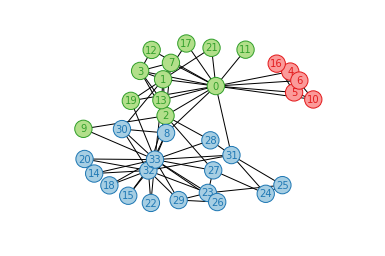

In [40]:
G=nx.karate_club_graph()

findCommunities(G)

drawNetwork(G)